# Preliminary BTFR sample stats

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import Table, join, vstack
from astropy.coordinates import SkyCoord
import astropy.units as u

In [11]:
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300

## read in tables

In [3]:
tf_loa = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/desi_pv_loa_healpix.fits')
tf_fuji = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
tf_combined = vstack([tf_fuji, tf_loa])

In [6]:
tf_combined[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SPECTYPE,PHOTSYS
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,bytes6,bytes1
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,--,--
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,--,--
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136,--,--
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595,--,--
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195,--,--


In [7]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [8]:
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [9]:
SGA_dict = {}
for i in range(len(SGA)):

    SGA_dict[SGA['SGA_ID'][i]] = i

## add number of observations at unique distances to SGA table

In [10]:
tf_combined['SKY_FIBER_DIST'] = 0.
tf_combined['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tf_combined['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tf_combined['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tf_combined['TARGET_RA'][obs_idx], 
                             dec=tf_combined['TARGET_DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tf_combined['SKY_FIBER_DIST'][obs_idx] = sep2d
    tf_combined['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|██████████| 147079/147079 [07:19<00:00, 334.86it/s]


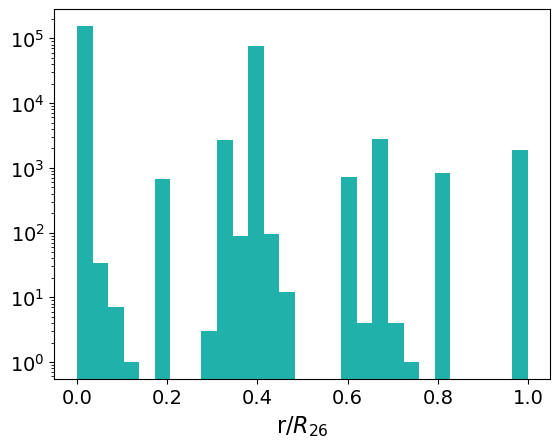

In [23]:
plt.hist(tf_combined['SKY_FIBER_DIST_R26'], bins=np.linspace(0,1,30), color='lightseagreen')
plt.xlabel('r/$R_{26}$', fontsize=16)
plt.yscale('log')
plt.tick_params(labelsize=14)

(array([ 152.,    0.,    0.,  674.,    0.,   34.,   46.,  374.,    0.,
           0.,  712.,    0.,   84.,    0.,  819.,    0.,    0.,    0.,
        1029.,    0.]),
 array([0.   , 0.055, 0.11 , 0.165, 0.22 , 0.275, 0.33 , 0.385, 0.44 ,
        0.495, 0.55 , 0.605, 0.66 , 0.715, 0.77 , 0.825, 0.88 , 0.935,
        0.99 , 1.045, 1.1  ]),
 <BarContainer object of 20 artists>)

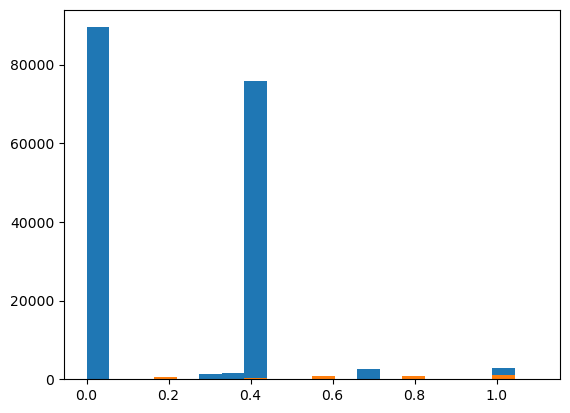

In [31]:
plt.hist(tf_combined[tf_combined['PVTYPE'] == 'TFT']['SKY_FIBER_DIST_R26'], bins=np.linspace(0,1.1,21))
plt.hist(tf_combined[tf_combined['PVTYPE'] == 'EXT']['SKY_FIBER_DIST_R26'], bins=np.linspace(0,1.1,21))

## count the number of observations at unique distances
different combinations of observations we can use
* TF: center, one observation on either side at 0.4 or 0.33 R26
* RC: center, two observations at unique distance (best)

In [74]:
SGA['N_OBS'] = np.zeros(len(SGA), dtype='int')
SGA['RC'] = np.zeros(len(SGA), dtype='int')
SGA['TF'] = np.zeros(len(SGA), dtype='int')

In [75]:
center_dist_lim = 0.001 # target distance from center that's still considered a center observation in units of R26
unique_dist_lim = 0.01 # minimum difference for distances to be considered unique in units of R26

In [76]:
for sga_id in tqdm(np.unique(tf_combined['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = np.logical_and(tf_combined['SGA_ID'] == sga_id, tf_combined['TARGETID'] > 0)
    
    obs = tf_combined[obs_idx]
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    # check that there are at least 3 observations on the galaxy
    if len(obs) >= 3:
        
        # check if galaxy has a center observation
        if np.any(obs['SKY_FIBER_DIST_R26'] < center_dist_lim):
            not_center = obs[obs['SKY_FIBER_DIST_R26'] > unique_dist_lim]
            
            if len(not_center) >= 2:
            
                #chekc that there are 2 unique distances (non-center)
                if (np.max(not_center['SKY_FIBER_DIST_R26']) - np.min(not_center['SKY_FIBER_DIST_R26'])) >= unique_dist_lim:

                    # galaxy passes criteria 1
                    SGA['RC'][sga_idx] = 1



100%|██████████| 147079/147079 [05:08<00:00, 476.05it/s]


In [77]:
for sga_id in tqdm(np.unique(tf_combined['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = np.logical_and(tf_combined['SGA_ID'] == sga_id, tf_combined['TARGETID'] > 0)

    obs = tf_combined[obs_idx]

    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]  
    
    if len(obs)>=3:

        
        # check if galaxy has a center observation
        if np.any(obs['SKY_FIBER_DIST_R26'] < center_dist_lim):

            # grab non center observations
            not_center = obs[obs['SKY_FIBER_DIST_R26'] > unique_dist_lim]

        

            # separate "left" and "right" observations
            left = not_center[not_center['TARGET_DEC'] - SGA['DEC'][sga_idx] > 0]
            right = not_center[not_center['TARGET_DEC'] - SGA['DEC'][sga_idx] < 0]

            if len(left) > 0 and len(right) > 0:

                # check that there are 2 observations at same distance on opposite sides
                for i in range(len(left)):
                    if np.any(right['SKY_FIBER_DIST_R26'] - left['SKY_FIBER_DIST_R26'][i] < unique_dist_lim):

                        SGA['TF'][sga_idx] = 1
                        continue

100%|██████████| 147079/147079 [05:33<00:00, 441.47it/s]


In [87]:
RC = SGA['RC']==1
TF = SGA['TF']==1

In [88]:
len(SGA[RC])

1805

In [89]:
len(SGA[TF])

15593

In [124]:
len(SGA[np.logical_and(RC,TF)])

1512

In [123]:
SGA.write('/pscratch/sd/n/nravi/BTFR/SGA_BTFR_tf_targets.fits')

## color dist

In [110]:
# cut galaxies without sga apparent mags
good_mag = SGA[np.logical_and(SGA['G_MAG_SB26'] != -1, SGA['Z_MAG_SB26'] != -1)]

In [111]:
good_mag_RC = good_mag['RC']==1
good_mag_TF = good_mag['TF']==1

Text(0.5, 0, '$g-z$')

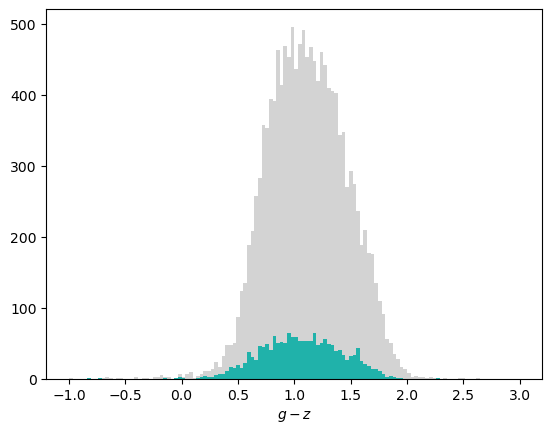

In [122]:
plt.hist(good_mag[np.logical_and(~good_mag_RC, good_mag_TF)]['G_MAG_SB26']
         - good_mag[np.logical_and(~good_mag_RC, good_mag_TF)]['Z_MAG_SB26'],
         bins=np.linspace(-1,3,125),
         color='lightgrey')

plt.hist(good_mag[good_mag_RC]['G_MAG_SB26']
         - good_mag[good_mag_RC]['Z_MAG_SB26'],
         bins=np.linspace(-1,3,125),
         color='lightseagreen')

plt.xlabel(r'$g-z$')